#### Imports

In [1]:
import carla
import json
import math
import random
import time
import numpy as np
import cv2
import open3d as o3d
import queue
from matplotlib import cm
import shutil 
import os
from enum import Enum

import sys
import numpy as np
import urdf_parser_py.urdf as urdf
from scipy.spatial.transform import Rotation   
import matplotlib.pyplot as plt
import open3d as o3d

import networkx as nx

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Connect to CARLA server

In [2]:
client = carla.Client('localhost', 2000)
client.set_timeout(10)
world = client.get_world()
map = world.get_map()

blueprint_library = world.get_blueprint_library()
spawn_points = world.get_map().get_spawn_points()

### Graph of junctions on the map

In [9]:
"""
Those helper classes are created because there were some inconsistencies
when storing carla.Waypoint and carla.Junction objects in sets and
dictionaries. The helper methods have custom __hash__ and __eq__ dunder
methods so that those objects can be stored in said data structures.
"""

class WaypointHelper:
    """Helper for carla.Waypoint."""
    def __init__(self, waypoint):
        self.waypoint = waypoint
        self.is_junction = waypoint.is_junction
    
    def __hash__(self) -> int:
        return self.waypoint.id
    
    def __eq__(self, other: object) -> bool:
        return self.waypoint.id == other.waypoint.id
    
    def get_junction(self):
        return self.waypoint.get_junction()

class JunctionHelper:
    """Helper for carla.Junction."""
    def __init__(self, junction) -> None:
        self.junction = junction
        self.id = junction.id

    def get_coords(self):
        loc = self.junction.bounding_box.location
        return (loc.x, loc.y)

    def __hash__(self) -> int:
        return self.junction.id
    
    def __eq__(self, o: object) -> bool:
        return self.junction.id == o.junction.id

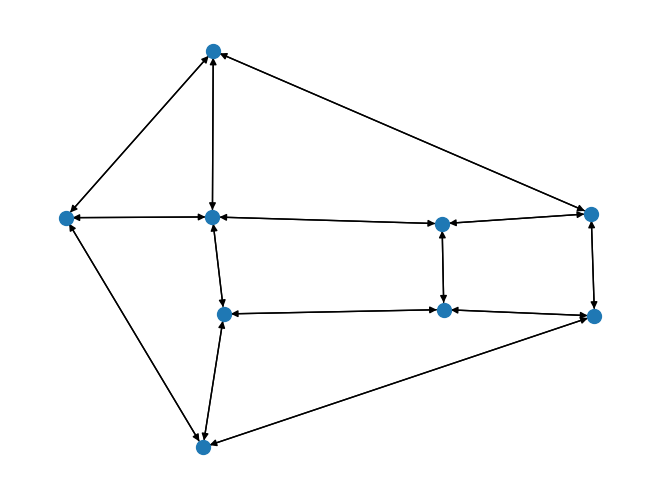

In [14]:
def create_junction_adjacency_dict(waypoint_adjacency_dict: dict) -> dict:
    """
    Create direct connections between junctions.
    Cut out the waypoints and lanes so that it's 
    easier to define a graph.

    Inputs:
        waypoint_connections - dictionary of WaypointHelper
        objects where the key is a waypoint and the value is 
        a list of waypoints that the key is directly connected to.
    Returns:
        A dictionary of JunctionHelper objects where the key is a 
        junction and the value is a list of junctions that the key
        is connected to.
    """
    junction_adjacency_dict = {}
    for k, v in waypoint_adjacency_dict.items():
        if k.is_junction:
            junction = JunctionHelper(k.get_junction())
            connected_junctions = set()
            to_visit = set(v)
            visited = set()
            while to_visit:
                n = to_visit.pop()
                if n in visited:
                    continue
                if n.is_junction:
                    connected_junctions.add(JunctionHelper(n.get_junction()))
                else:
                    to_visit.update(waypoint_adjacency_dict[n])
                visited.add(n)
            junction_adjacency_dict.setdefault(junction, set()).update(connected_junctions)
    return junction_adjacency_dict


def create_waypoint_adjacency_dict(topology: list) -> dict:
    """
    Turn the list of waypoint edges into an adjacency dict 
    consisting of WaypointHelper objects where the key is a
    waypoint and the value is a list of waypoints that the key
    connects to.
    Inputs:
        topology - a list of tuples where each tuple contains two 
        carla.Waypoint objects, representing the start and end of
        an adge in the map topology
    Returns:
        A dictionary of WaypointHelper objects where the key is a
        a waypoint and the value is a list of waypoints that the
        key connects to.
    """
    waypoint_adjacency_dict = {}
    for w1, w2 in topology:
        wp1 = WaypointHelper(w1)
        wp2 = WaypointHelper(w2)
        waypoint_adjacency_dict.setdefault(wp1, []).append(wp2)
    return waypoint_adjacency_dict


def draw_junction_graph(junction_adjacency_dict: dict) -> None:
    """
    Build and display the junction graph of the map.
    Inputs:
        junction_adjacency_dict - dictionary of JunctionHelper
        objects where the key is a junction and the value is a
        list of junctions that the key connects to.
    """
    G = nx.DiGraph()
    for node, connections in junction_adjacency_dict.items():
        for conn in connections:
            node_x, node_y = node.get_coords()
            conn_x, conn_y = conn.get_coords()
            G.add_node(node.id, pos=(node_x, node_y))
            G.add_node(conn.id, pos=(conn_x, conn_y))
            G.add_edge(node.id, conn.id)

    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G,
            pos=pos,
            with_labels=False,
            node_size=100)


def create_junction_graph(draw_graph: bool=False) -> dict:
    """
    Create a directed graph that represents connections between
    junctions on the map. Nodes are the mid-points of junctions
    and edges are connections between the junctions.

    Inputs:
        draw_graph - boolean for determining whether to draw and display
        the graph
    """
    topology = map.get_topology()
    waypoint_adjacency_dict = create_waypoint_adjacency_dict(topology)
    junction_adjacency_dict = create_junction_adjacency_dict(waypoint_adjacency_dict)

    if draw_graph:
        draw_junction_graph(junction_adjacency_dict)

    return junction_adjacency_dict

junction_graph = create_junction_graph(draw_graph=True)

In [5]:
def reload_world():
    global world, map, blueprint_library, spawn_points, traffic_manager
    world = client.reload_world()
    map = world.get_map()
    blueprint_library = world.get_blueprint_library()
    spawn_points = world.get_map().get_spawn_points()
    traffic_manager = client.get_trafficmanager()

def load_world(map_name="Town01", timeout=10.0):
    global world, map, blueprint_library, spawn_points, traffic_manager
    client.set_timeout(timeout)
    world = client.load_world(map_name)
    map = world.get_map()
    blueprint_library = world.get_blueprint_library()
    spawn_points = world.get_map().get_spawn_points()
    traffic_manager = client.get_trafficmanager()

In [6]:
class CarlaSyncMode(object):
    """
        with CarlaSyncMode(world, sensors) as sync_mode:
            while True:
                data = sync_mode.tick(timeout=1.0)

    """

    def __init__(self, world, sensors, **kwargs):
        self.world = world
        self.sensors = sensors
        self.frame = None
        self.delta_seconds = 1.0 / kwargs.get('fps', 5)
        self._queues = []
        self._settings = None

    def __enter__(self):
        self._settings = self.world.get_settings()
        self.frame = self.world.apply_settings(carla.WorldSettings(
            no_rendering_mode=False,
            synchronous_mode=True,
            fixed_delta_seconds=self.delta_seconds,
            ))

        def make_queue(register_event):
            q = queue.Queue()
            register_event(q.put)
            self._queues.append(q)

        make_queue(self.world.on_tick)
        for sensor in self.sensors:
            make_queue(sensor.listen)
        return self

    def tick(self, timeout):
        self.frame = self.world.tick()
        data = [self._retrieve_data(q, timeout) for q in self._queues]
        assert all(x.frame == self.frame for x in data)
        return data

    def __exit__(self, *args, **kwargs):
        self.world.apply_settings(self._settings)

    def _retrieve_data(self, sensor_queue, timeout):
        while True:
            data = sensor_queue.get(timeout=timeout)
            if data.frame == self.frame:
                return data

#### Read simulation configuration file

In [7]:
def get_value(data_dict, keys, default=None):
    for key in keys:
        if isinstance(data_dict, dict):
            data_dict = data_dict.get(key, default)
        else:
            return default
    return data_dict

In [8]:
def matrix_to_transform(matrix):
    # Extract translation
    location = carla.Location(x=matrix[0, 3], y=(-matrix[1, 3]), z=matrix[2, 3])

    roll, pitch, yaw = Rotation.from_matrix(matrix[:3, :3]).as_euler('xyz', degrees=True)
    rotation = carla.Rotation(pitch=(-pitch), yaw=(-yaw), roll=roll)
    
    # Create and return carla.Transform
    return carla.Transform(location, rotation)


def build_transform_matrix(rotation, translation):
    m = np.eye(4)
    m[:3, :3] = rotation
    m[:3, 3] = translation
    return m


def rotation_matrix(axis, angle):
    """
    Create a rotation matrix for a given axis and angle.
    """
    if axis == 'x':
        return np.array([
            [1, 0, 0, 0],
            [0, np.cos(angle), -np.sin(angle), 0],
            [0, np.sin(angle), np.cos(angle), 0],
            [0, 0, 0, 1]
        ])
    elif axis == 'y':
        return np.array([
            [np.cos(angle), 0, np.sin(angle), 0],
            [0, 1, 0, 0],
            [-np.sin(angle), 0, np.cos(angle), 0],
            [0, 0, 0, 1]
        ])
    elif axis == 'z':
        return np.array([
            [np.cos(angle), -np.sin(angle), 0, 0],
            [np.sin(angle), np.cos(angle), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

def reflection_matrix():
    """
    Create a reflection matrix to flip the Y-axis.
    """
    return np.array([
        [1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def transform_to_carla(sensor_type, transformation):
    """
    Convert sensor transformation to CARLA format.
    """
    if sensor_type == 'camera':
        rotation1 = rotation_matrix('z', np.pi / 2)
        rotation2 = rotation_matrix('y', -np.pi / 2)
        # rotation2 = np.eye(4)
        rotation = np.dot(rotation1, rotation2)
    elif sensor_type == 'lidar':
        rotation = rotation_matrix('z', np.pi / 2)
    elif sensor_type == 'radar':
        rotation = np.eye(4) #rotation_matrix('x', np.pi / 2)
    else:
        raise ValueError("Unknown sensor type")
    
    tf = np.dot(transformation, rotation)
    #reflection = reflection_matrix()
    #tf = np.dot(reflection, tf)
    return tf


class URDFParser:
    def __init__(self, urdf_file):
        self.urdf_file = urdf_file
        self.robot = urdf.URDF.from_xml_file(urdf_file)
        self.root = self.robot.get_root()

    def compute_chain_transform(self, chain):
        transform = np.eye(4)
        
        for joint in chain:
            if joint not in self.robot.joint_map:
                continue
            
            joint_info = self.robot.joint_map[joint]
            rpy = joint_info.origin.rpy
            xyz = joint_info.origin.xyz
            rotation = Rotation.from_euler('xyz', rpy).as_matrix()
            translation = np.array(xyz)
            T = build_transform_matrix(rotation, translation)
            transform = np.dot(transform, T)
        
        return transform

    def get_T_from_to(self, start_frame, end_frame):
        chain_1 = self.robot.get_chain(self.root, start_frame)
        chain_2 = self.robot.get_chain(self.root, end_frame)
        T1 = self.compute_chain_transform(chain_1)
        T2 = self.compute_chain_transform(chain_2)
        return np.dot(np.linalg.inv(T1), T2)

    def visualize(self, start_frame, end_frame):
        fig = plt.figure(figsize=[6, 6])
        ax = fig.add_subplot(111, projection='3d')
        
        for link in self.robot.links:
            name = link.name
            base_T_link = self.compute_chain_transform(self.robot.get_chain(self.root, name))
            
            linewidth = 1
            if name == start_frame or name == end_frame:
                linewidth = 5
                ax.text(*base_T_link[:3, 3], name, fontsize=12)
                
            ax.quiver(*base_T_link[:3, 3], *base_T_link[:3, 0], color='r', linewidth=linewidth, length=0.2)  # X axis
            ax.quiver(*base_T_link[:3, 3], *base_T_link[:3, 1], color='g', linewidth=linewidth, length=0.2)  # Y axis
            ax.quiver(*base_T_link[:3, 3], *base_T_link[:3, 2], color='b', linewidth=linewidth, length=0.2)  # Z axis

        ax.set_box_aspect([1, 1, 1])

        # Show the plot
        plt.show()
        
    def visualize_o3d(self, start_frame, end_frame):
        # Create a visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window()

        for link in self.robot.links:
            name = link.name
            base_T_link = self.compute_chain_transform(self.robot.get_chain(self.root, name))

            scale = 0.2
            if name == start_frame or name == end_frame:
                scale = 0.3

            if 'LIDAR' in name:
                base_T_link = transform_to_carla('lidar', base_T_link)
            elif 'CAM' in name:
                base_T_link = transform_to_carla('camera', base_T_link)
            elif 'RADAR' in name:
                base_T_link = transform_to_carla('radar', base_T_link)

                
            # Create a coordinate frame at the link position
            frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=scale)
            frame.transform(base_T_link)

            # If the link is the start or end frame, scale the frame for emphasis
             

            # Add the frame to the visualizer
            vis.add_geometry(frame)

        # Run the visualizer
        vis.run()

        # Destroy the visualizer when done
        vis.destroy_window()

In [9]:
extrinsics = URDFParser('config/nuscenes.extrinsics.urdf')
for link in extrinsics.robot.links:
    name = link.name
    base_T_link = extrinsics.compute_chain_transform(extrinsics.robot.get_chain(extrinsics.root, name))
    if 'LIDAR' in name:
        base_T_link = transform_to_carla('lidar', base_T_link)
    elif 'CAM' in name:
        base_T_link = transform_to_carla('camera', base_T_link)
    elif 'RADAR' in name:
        base_T_link = transform_to_carla('radar', base_T_link)

    xyz = base_T_link[:3, 3]
    rpy = Rotation.from_matrix(base_T_link[:3, :3]).as_euler('xyz')
    print(f"{name}: xyz={xyz}, rpy={rpy}")
    

CAM_BACK_RIGHT: xyz=[ 1.0148781  -0.48056822  1.56239545], rpy=[ 0.01080667  0.01626668 -1.93363654]
RADAR_FRONT_LEFT: xyz=[2.422 0.8   0.78 ], rpy=[0.         0.         1.54217293]
RADAR_FRONT_RIGHT: xyz=[ 2.422 -0.8    0.77 ], rpy=[ 0.          0.         -1.58790055]
base_link: xyz=[0. 0. 0.], rpy=[0. 0. 0.]
RADAR_FRONT: xyz=[3.412 0.    0.5  ], rpy=[0.         0.         0.00349066]
RADAR_BACK_LEFT: xyz=[-0.562  0.628  0.53 ], rpy=[0.         0.         3.04402875]
LIDAR_TOP: xyz=[0.943713 0.       1.84023 ], rpy=[0.00590142 0.02423173 0.0021763 ]
CAM_FRONT: xyz=[1.70079119 0.01594563 1.51095764], rpy=[-0.00080508  0.00564136  0.00568027]
CAM_FRONT_RIGHT: xyz=[ 1.55084775 -0.4934048   1.49574801], rpy=[ 0.00905638  0.01364833 -0.98431885]
CAM_BACK_LEFT: xyz=[1.035691   0.48479503 1.59097015], rpy=[-0.00375613  0.0160109   1.89537173]
CAM_FRONT_LEFT: xyz=[1.52387798 0.49463134 1.50932822], rpy=[ 0.00211947 -0.00244738  0.96273526]
CAM_BACK: xyz=[0.02832603 0.00345137 1.57910346], r

### Add pedestrians to simulation

In [10]:
def add_pedestrians_to_simulation(n_pedestrians: int=0,
                                  min_speed: float=1.0,
                                  max_speed: float=2.0) -> None:
    """
    Choose n_pedestrians amount of random pedestrians from Carla's
    Blueprint Library, attach them to AI and spawn them to random 
    positions in the simulation. Set a random location for them to 
    walk to and speed between min_speed and max_speed for them to
    walk at.

    NB! If the randomly chosen spawn points collide, a pedestrian
    is not spawned, so there might be fewer pedestrians than 
    n_pedestrians in the simulation.

    Inputs:
        n_pedestrians - number of pedestrians to spawn
        min_speed - minimum walking speed for a pedestrian
        max_speed - maximum walking speed for a pedestrian
    """
    if n_pedestrians == 0:
        return
    
    pedestrian_blueprints = blueprint_library.filter("walker.pedestrian.*")
    points = []
    for i in range(n_pedestrians):
        point = carla.Transform()
        point.location = world.get_random_location_from_navigation()
        if (point.location != None):
            points.append(point)
    batch = []

    # Create a batch of spawn commands
    for point in points:
        pedestrian_bp = random.choice(pedestrian_blueprints)
        batch.append(carla.command.SpawnActor(pedestrian_bp, point))

    # Apply the batch of commands
    results = client.apply_batch_sync(batch, True)
    walkers_list = []
    collisions = 0
    for i in range(len(results)):
        if results[i].error:
            collisions += 1
        else:
            walkers_list.append({"id": results[i].actor_id})

    if collisions:
        print(f"Failed to spawn {collisions}/{n_pedestrians} pedestrians because of collisions")

    # Create a batch of spawn commands for AI controllers
    batch = []
    walker_controller_bp = blueprint_library.find('controller.ai.walker')
    for i in range(len(walkers_list)):
        batch.append(carla.command.SpawnActor(walker_controller_bp, carla.Transform(), walkers_list[i]["id"]))

    # Apply the batch of commands
    results = client.apply_batch_sync(batch, True)
    for i in range(len(results)):
        if results[i].error:
            print(f"Spawning pedestrian AI failed: {results[i].error}")
        else:
            walkers_list[i]["con"] = results[i].actor_id

    all_ids = []
    for i in range(len(walkers_list)):
        all_ids.append(walkers_list[i]["con"])
        all_ids.append(walkers_list[i]["id"])
    all_actors = world.get_actors(all_ids)

    for i in range(0, len(all_actors), 2):
        all_actors[i].start()
        all_actors[i].go_to_location(world.get_random_location_from_navigation())
        all_actors[i].set_max_speed(random.uniform(min_speed, max_speed))

### Add vehicles to simulation

In [11]:
def add_vehicles_to_simulation(n_vehicles: int=0):
    """
    Choos n_vehicles amount of vehicles from Carla's Blueprint Library and
    spawn them at random points on the map. Each of those vehicles are set
    on autopilot and controlled by Carla's Traffic Manager.
    
    NB! If randomly chosen spawn points collide, the vehicle is not spawned
    so there might be fewer vehicles than set by n_vehicles.

    Inputs:
        n_vehicles - amount of vehicles to spawn
    """
    if n_vehicles == 0:
        return
    
    vehicle_blueprints = blueprint_library.filter('vehicle')
    
    npcs = []
    collisions = 0
    for _ in range(n_vehicles):
        vehicle_bp = random.choice(vehicle_blueprints)
        spawn_point = random.choice(spawn_points)
        npc = world.try_spawn_actor(vehicle_bp, spawn_point)
        if npc:
            npcs.append(npc)
        else:
            collisions += 1
    
    if collisions:
        print(f"Failed to spawn {collisions}/{n_vehicles} vehicles because of collisions")
    
    port = traffic_manager.get_port()
    for npc in npcs:
        npc.set_autopilot(True, port)

### Apply configuration

In [12]:
reload_world()

vehicles = []
blueprint_name = "vehicle.mini.cooper_s_2021"
blueprint = blueprint_library.find(blueprint_name)
blueprint.set_attribute('role_name','ego')
transform = spawn_points[20]
vehicle = world.spawn_actor(blueprint, transform)
port = traffic_manager.get_port()
vehicle.set_autopilot(True, port)
vehicles.append(vehicle)

sensor_names = []
sensor_types = []
sensors = []

axes = []

extrinsics = URDFParser('config/nuscenes_car.urdf')
intrinsics = dict()
with open('config/nuscenes.intrinsics.json') as intrinsics_file:
    intrinsics = json.load(intrinsics_file)

for sensor_configuration in extrinsics.robot.links:
    sensor_name = sensor_configuration.name

    if "_DEPTH_CAM_" in sensor_name:
        blueprint_name = "sensor.camera.depth"
        blueprint = blueprint_library.find(blueprint_name)
        sensor_intrinsics = get_value(intrinsics, [sensor_name], default=dict())
        image_width = str(sensor_intrinsics.get("w", 1600))
        blueprint.set_attribute('image_size_x', image_width)
        image_height = str(sensor_intrinsics.get("h", 900))
        field_of_view = str(sensor_intrinsics.get("fov", 120))
        blueprint.set_attribute('image_size_y', image_height)
        blueprint.set_attribute('fov', field_of_view)
        
        transform_matrix = extrinsics.get_T_from_to("center", sensor_name)
        transform_matrix = transform_to_carla('camera', transform_matrix)
        transform = matrix_to_transform(transform_matrix)
        attached_to = vehicle
        sensor = world.spawn_actor(blueprint, transform, attach_to=attached_to)

    elif "_SEMANTIC_CAM_" in sensor_name:
        blueprint_name = "sensor.camera.semantic_segmentation"
        blueprint = blueprint_library.find(blueprint_name)
        sensor_intrinsics = get_value(intrinsics, [sensor_name], default=dict())
        image_width = str(sensor_intrinsics.get("w", 1600))
        blueprint.set_attribute('image_size_x', image_width)
        image_height = str(sensor_intrinsics.get("h", 900))
        field_of_view = str(sensor_intrinsics.get("fov", 120))
        blueprint.set_attribute('image_size_y', image_height)
        blueprint.set_attribute('fov', field_of_view)
        
        transform_matrix = extrinsics.get_T_from_to("center", sensor_name)
        transform_matrix = transform_to_carla('camera', transform_matrix)
        transform = matrix_to_transform(transform_matrix)
        attached_to = vehicle
        sensor = world.spawn_actor(blueprint, transform, attach_to=attached_to)

    elif "CAM_" in sensor_name:
        blueprint_name = "sensor.camera.rgb"
        blueprint = blueprint_library.find(blueprint_name)
        sensor_intrinsics = get_value(intrinsics, [sensor_name], default=dict())
        focal_distance = str(sensor_intrinsics.get("fl", 1260.0))
        blueprint.set_attribute("focal_distance", focal_distance)
        image_width = str(sensor_intrinsics.get("w", 1600))
        blueprint.set_attribute('image_size_x', image_width)
        image_height = str(sensor_intrinsics.get("h", 900))
        blueprint.set_attribute('image_size_y', image_height)
        
        transform_matrix = extrinsics.get_T_from_to("center", sensor_name)
        transform_matrix = transform_to_carla('camera', transform_matrix)
        transform = matrix_to_transform(transform_matrix)
        attached_to = vehicle
        sensor = world.spawn_actor(blueprint, transform, attach_to=attached_to)

    elif "RADAR_" in sensor_name:
        blueprint_name = "sensor.other.radar"
        blueprint = blueprint_library.find(blueprint_name)     
        blueprint.set_attribute('horizontal_fov', str(30.0)) 
        blueprint.set_attribute('vertical_fov', str(30.0)) 
        blueprint.set_attribute('points_per_second', str(1e5))
        
        transform_matrix = extrinsics.get_T_from_to("center", sensor_name)
        transform_matrix = transform_to_carla('radar', transform_matrix)
        transform = matrix_to_transform(transform_matrix)
        attached_to = vehicle
        sensor = world.spawn_actor(blueprint, transform, attach_to=attached_to)



    elif "LIDAR_" in sensor_name:
        blueprint_name = "sensor.lidar.ray_cast_semantic"
        blueprint = blueprint_library.find(blueprint_name)
        blueprint.set_attribute("channels", str(64))
        blueprint.set_attribute("points_per_second", str(112000))
        blueprint.set_attribute("range", str(100))
        
        transform_matrix = extrinsics.get_T_from_to("center", sensor_name)
        transform_matrix = transform_to_carla('lidar', transform_matrix)
        transform = matrix_to_transform(transform_matrix)
        attached_to = vehicle
        sensor = world.spawn_actor(blueprint, transform, attach_to=attached_to)

    else:
        continue

    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=[0, 0, 0])
    frame.transform(transform_matrix)
    axes.append(frame)
        
    sensors.append(sensor)
    sensor_type = blueprint_name
    sensor_types.append(sensor_type)
    sensor_names.append(sensor_name)

#o3d.visualization.draw_geometries(axes)
add_pedestrians_to_simulation()
add_vehicles_to_simulation()

In [13]:
print(f"Number of sensors spawned: {len(sensors)}")
print(sensor_names)
print(sensor_types)

Number of sensors spawned: 12
['CAM_BACK_RIGHT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_FRONT', 'RADAR_BACK_LEFT', 'LIDAR_TOP', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_FRONT_LEFT', 'CAM_BACK', 'RADAR_BACK_RIGHT']
['sensor.camera.rgb', 'sensor.other.radar', 'sensor.other.radar', 'sensor.other.radar', 'sensor.other.radar', 'sensor.lidar.ray_cast_semantic', 'sensor.camera.rgb', 'sensor.camera.rgb', 'sensor.camera.rgb', 'sensor.camera.rgb', 'sensor.camera.rgb', 'sensor.other.radar']


### Helper methods:

##### Filesystem methods

In [14]:
def delete_all_in_directory(target_directory):
    if os.path.exists(target_directory):
        for filename in os.listdir(target_directory):
            file_path = os.path.join(target_directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.remove(file_path) 
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')


def create_filename_from_timestamp(timestamp):
    SECONDS_TO_NANOSECONDS = 1000000000
    filename = str(math.trunc(timestamp * SECONDS_TO_NANOSECONDS))
    return filename


##### General sensor processing methods

In [15]:
def save_sensor_position(raw_data, target_directory):
    transform = raw_data.transform
    transform_matrix = raw_data.transform.get_matrix()
    if not os.path.exists(target_directory):
        os.makedirs(target_directory, exist_ok=True)
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".npy"
    np.save(f"{target_directory}/{filename}", transform_matrix)

##### RBG Camera Methods

In [16]:
def save_rgb_image(raw_data, target_directory):    
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    rgb_image = np.reshape(np.copy(raw_data.raw_data), (raw_data.height, raw_data.width, 4))
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".png"
    cv2.imwrite(f"{directory}/{filename}", rgb_image)

def visualize_rgb_image(raw_image, window_name, window_size=None):
    image = np.reshape(np.copy(raw_image.raw_data), (raw_image.height, raw_image.width, 4))
    if window_size:
         image = cv2.resize(image, dsize=window_size, interpolation=cv2.INTER_CUBIC)
    cv2.imshow(window_name, image)

##### Depth Camera Methods

In [17]:
def visualize_depth_image(raw_image, window_name, window_size=None):
    image = np.reshape(np.copy(raw_image.raw_data), (raw_image.height, raw_image.width, 4))
    if window_size:
         image = cv2.resize(image, dsize=window_size, interpolation=cv2.INTER_CUBIC)
    cv2.imshow(window_name, image)

def save_depth_image(raw_data, target_directory):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".png"
    raw_data.save_to_disk(f"{directory}/{filename}")

def convert_depth_image_to_depth_map(image):
    depth_map = image[:, :, 0] + image[:, :, 1] * 256 + image[:, :, 2] * 256**2
    depth_map = depth_map / (256**3 - 1) * 1000  # Convert to meters
    return depth_map

##### Semantic Camera Methods

In [18]:
class SemanticColors(Enum):
    UNLABELED =     (0, 0, 0)
    BUILDING =      (1, 0, 0)
    FENCE =         (2, 0, 0)
    OTHER =         (3, 0, 0)
    PEDESTRIAN =    (4, 0, 0)
    POLE =          (5, 0, 0)
    ROADLINE =      (6, 0, 0)
    ROAD =          (7, 0, 0)
    SIDEWALK =      (8, 0, 0)
    VEGETATION =    (9, 0, 0)
    VEHICLES =      (10, 0, 0)
    WALL =          (11, 0, 0)
    TRAFFICSIGN =   (12, 0, 0)
    SKY =           (13, 0, 0)
    GROUND =        (14, 0, 0)
    BRIDGE =        (15, 0, 0)
    RAILTRACK =     (16, 0, 0)
    GUARDRAIL =     (17, 0, 0)
    TRAFFICLIGHT =  (18, 0, 0)
    STATIC =        (19, 0, 0)
    DYNAMIC =       (20, 0, 0)
    WATER =         (21, 0, 0)
    TERRAIN =       (22, 0, 0)

def create_color_mask(image, colors):
    mask = np.full((image.shape[0], image.shape[1]), 255, dtype=np.uint8)
    
    B, G, R = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    # Iterate through the list of colors
    for color in colors:
        # Extract color channels
        r, g, b = color
        # Create boolean masks for each channel comparison
        r_mask = R == r
        g_mask = G == g
        b_mask = B == b
        # Combine channel masks to get the final color mask
        color_mask = r_mask & g_mask & b_mask
        # Update the overall mask where any color matches
        mask[color_mask] = 0
    return mask

def visualize_semantic_image(raw_image, window_name, window_size=None):
    image = np.reshape(np.copy(raw_image.raw_data), (raw_image.height, raw_image.width, 4))
    if window_size:
         image = cv2.resize(image, dsize=window_size, interpolation=cv2.INTER_CUBIC)
    cv2.imshow(window_name, image)

def save_semantic_image(raw_data, target_directory):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".png"
    raw_data.save_to_disk(f"{directory}/{filename}")

def save_semantic_image_mask(raw_data, target_directory, masked_colors=[]):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    semantic_image = np.reshape(np.copy(raw_data.raw_data), (raw_data.height, raw_data.width, 4))
    mask = create_color_mask(semantic_image, masked_colors)

    filename = create_filename_from_timestamp(raw_data.timestamp) + ".mask.png"
    cv2.imwrite(f"{directory}/{filename}", mask)

##### Radar Methods

In [19]:
def save_radar_readings(raw_data, target_directory):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    points = []

    # Convert radar readings to 3D points (spherical to Cartesian)
    radar_measurement = raw_data
    
    current_rot = raw_data.transform.rotation
    current_trans = raw_data.transform.location

    radar_points_list = []
    for detect in radar_measurement:
        azi = math.degrees(detect.azimuth)
        alt = math.degrees(detect.altitude)
        # The 0.25 adjusts a bit the distance so the dots can
        # be properly seen
        fw_vec = carla.Vector3D(x=detect.depth)
        
        carla.Transform(
                carla.Location(),
                carla.Rotation(
                    pitch=alt,
                    yaw=azi,
                    roll=0)).transform(fw_vec)
        
        
        radar_points_list.append([fw_vec.x, fw_vec.y, fw_vec.z])
        
        # norm_velocity = detect.velocity / self.velocity_range # range [-1, 1]
        # r = int(clamp(0.0, 1.0, 1.0 - norm_velocity) * 255.0)
        # g = int(clamp(0.0, 1.0, 1.0 - abs(norm_velocity)) * 255.0)
        # b = int(abs(clamp(- 1.0, 0.0, - 1.0 - norm_velocity)) * 255.0)
    
    points = np.array(radar_points_list)
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".ply"
    o3d.io.write_point_cloud(f"{directory}/{filename}", point_cloud)
    
    # for detection in radar_measurement:
    #     # Extract the azimuth, altitude, depth from the radar detection
    #     azimuth = detection.azimuth
    #     altitude = detection.altitude
    #     depth = detection.depth

    #     # Convert spherical coordinates to Cartesian coordinates
    #     x = depth * np.cos(altitude) * np.cos(azimuth)
    #     y = depth * np.cos(altitude) * np.sin(azimuth)
    #     z = depth * np.sin(altitude)
        
    #     points.append([x, y, z])

    # # Create an Open3D point cloud object
    # point_cloud = o3d.geometry.PointCloud()
    # point_cloud.points = o3d.utility.Vector3dVector(points)

    # # Save the point cloud to a .ply file
    # filename = create_filename_from_timestamp(raw_data.timestamp) + ".ply"
    # o3d.io.write_point_cloud(f"{directory}/{filename}", point_cloud)


def visualize_radar(raw_data, window_name, max_distance = 100, image_size=(200, 200)):
    # Get the radar data
    radar_data = raw_data.raw_data
    points = np.frombuffer(radar_data, dtype=np.dtype('f4'))
    points = np.reshape(points, (len(raw_data), 4))

    # Extract information from radar points
    azimuths = points[:, 1]
    depths = points[:, 3]
    X = np.cos(azimuths) * depths
    Y = np.sin(azimuths) * depths

    def normalize(data):
        shifted = data - np.min(data)
        normal = shifted / np.max(shifted)
        return normal
    width, height = 360, 360
    X_norm = (normalize(X) * (width-1)).astype(int)
    Y_norm = (normalize(Y) * (height-1)).astype(int)

    radar_image_array = np.zeros((height, width))
    radar_image_array[Y_norm, X_norm] = 255  # Set a constant value for visibility
    cv2.imshow(window_name, radar_image_array)

##### Lidar methods

In [20]:
def visualize_lidar(raw_data, window_name):
    # Get the LiDAR point cloud from the data
    lidar_data = raw_data.raw_data
    lidar_data = np.frombuffer(lidar_data, dtype=np.dtype('f4'))
    lidar_data = np.reshape(lidar_data, (int(lidar_data.shape[0] / 4), 4))

    # Extract X, Y, Z coordinates and intensity values
    points_xyz = lidar_data[:, :3]
    #intensity = lidar_data[:, 3]

    # Intensity scaling factor
    intensity_scale = 2.0  # Adjust this value to control the brightness

    # Create a 2D histogram with a predetermined size
    width, height = 360, 360
    lidar_image_array = np.zeros((height, width))

    # Scale and shift X and Y coordinates to fit within the histogram size
    def normalize(data):
        shifted = data - np.min(data)
        normal = shifted / np.max(shifted)
        return normal
    X = (normalize(points_xyz[:, 0]) * (width-1)).astype(int)
    Y = (normalize(points_xyz[:, 1]) * (height-1)).astype(int)

    # Assign scaled intensity values to the corresponding pixel in the histogram
    lidar_image_array[Y, X] = 255

    # Display the processed image using Pygame
    cv2.imshow(window_name, lidar_image_array)

def save_lidar_readings(raw_data, target_directory):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".ply"
    raw_data.save_to_disk(f"{directory}/{filename}")

##### Semantic Lidar Methods

In [21]:
class SemanticTags(Enum):
    UNLABELED =     0
    BUILDING =      1
    FENCE =         2
    OTHER =         3
    PEDESTRIAN =    4
    POLE =          5
    ROADLINE =      6
    ROAD =          7
    SIDEWALK =      8
    VEGETATION =    9
    VEHICLES =      10
    WALL =          11
    TRAFFICSIGN =   12
    SKY =           13
    GROUND =        14
    BRIDGE =        15
    RAILTRACK =     16
    GUARDRAIL =     17
    TRAFFICLIGHT =  18
    STATIC =        19
    DYNAMIC =       20
    WATER =         21
    TERRAIN =       22


def filter_semantic_lidar_readings(semantic_lidar_data):
    #print(np.unique(semantic_tags, return_counts=True))
    filtered_lidar_data = np.copy(semantic_lidar_data)
    
    unwanted_data_tags = np.array([
        SemanticTags.ROADLINE.value, SemanticTags.ROAD.value, SemanticTags.SIDEWALK.value,
        SemanticTags.GROUND.value, SemanticTags.WATER.value, SemanticTags.TERRAIN.value
    ]) 
    if len(unwanted_data_tags) > 0:
        data_tags = filtered_lidar_data[:, 3].flatten()
        filter_mask = np.isin(data_tags, unwanted_data_tags, invert=True)
        filtered_lidar_data = filtered_lidar_data[filter_mask]
    
    z_range = None
    if z_range:
        z_min, z_max = z_range
        z_values = filtered_lidar_data[:, 2:3].flatten()
        filter_mask = np.where(z_min <= z_values, True, False) * np.where(z_values <= z_max, True, False)
        filtered_lidar_data = filtered_lidar_data[filter_mask]
    
    return filtered_lidar_data

def visualize_semantic_lidar(raw_data, window_name):
    # Get the LiDAR point cloud from the data
    lidar_data = np.array([(detection.point.x, detection.point.y, detection.point.z, int(detection.object_tag)) for detection in raw_data])
    lidar_data = filter_semantic_lidar_readings(lidar_data)

    # Extract X, Y, Z coordinates and intensity values
    points_xyz = lidar_data[:, :3]

    # Create a 2D histogram with a predetermined size
    width, height = 360, 360
    lidar_image_array = np.zeros((height, width))

    # Scale and shift X and Y coordinates to fit within the histogram size
    def normalize(data):
        shifted = data - np.min(data)
        normal = shifted / np.max(shifted)
        return normal
    X = (normalize(points_xyz[:, 0]) * (width-1)).astype(int)
    Y = (normalize(points_xyz[:, 1]) * (height-1)).astype(int)

    # Assign scaled intensity values to the corresponding pixel in the histogram
    lidar_image_array[Y, X] = 255

    # Display the processed image using Pygame
    cv2.imshow(window_name, lidar_image_array)

def save_semantic_lidar_readings(raw_data, target_directory):
    directory = os.path.dirname(target_directory)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    lidar_data = np.array([(detection.point.x, detection.point.y, detection.point.z, int(detection.object_tag)) for detection in raw_data])
    lidar_data = filter_semantic_lidar_readings(lidar_data)
    points = lidar_data[:, :3]
    # Create an Open3D point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)

    # Save the point cloud to a .ply file
    filename = create_filename_from_timestamp(raw_data.timestamp) + ".ply"
    o3d.io.write_point_cloud(f"{target_directory}/{filename}", point_cloud)

#### Running the simulation

In [22]:
SIMULATED_DATA_DIRECTORY = "./generated_data"
delete_all_in_directory(SIMULATED_DATA_DIRECTORY)

cv2.namedWindow("Press Q to stop simulation")
cv2.imshow("Press Q to stop simulation", np.zeros((1,1)))

try:
    with CarlaSyncMode(world, sensors, fps=10) as sync_mode:
        while True:
            simulation_results = sync_mode.tick(timeout=300.0)[1:]
            for i in range(len(simulation_results)):
                sensor = sensors[i]
                sensor_data = simulation_results[i]
                sensor_name = sensor_names[i].replace("base_link_to_", "")
                sensor_type = sensor_types[i]
                if ("camera.rgb" in sensor_type):
                    #visualize_rgb_image(sensor_data, sensor_name, window_size = (480, 270))
                    save_rgb_image(sensor_data, f"generated_data/{sensor_name}/")
                elif ("camera.semantic_segmentation" in sensor_type):
                    #visualize_semantic_image(sensor_data, sensor_name, window_size = (480, 270))
                    save_semantic_image(sensor_data, f"generated_data/{sensor_name}/")
                    save_semantic_image_mask(sensor_data, f"generated_data/{sensor_name}/", masked_colors=[
                        SemanticColors.ROADLINE.value, SemanticColors.ROAD.value, SemanticColors.SIDEWALK.value,
                        SemanticColors.GROUND.value, SemanticColors.WATER.value, SemanticColors.TERRAIN.value,
                        SemanticColors.SKY.value
                    ])
                elif ("sensor.other.radar" in sensor_type):
                    #visualize_radar(sensor_data, sensor_name)
                    save_radar_readings(sensor_data, f"generated_data/{sensor_name}/")
                elif ("camera.depth" in sensor_type):
                    #visualize_depth_image(sensor_data, sensor_name, window_size = (480, 270))
                    save_depth_image(sensor_data, f"generated_data/{sensor_name}/") 
                elif ("sensor.lidar.ray_cast_semantic" in sensor_type):
                    #visualize_semantic_lidar(sensor_data, sensor_name)
                    save_semantic_lidar_readings(sensor_data, f"generated_data/{sensor_name}/")
                elif ("sensor.lidar" in sensor_type):
                    #visualize_lidar(sensor_data, sensor_name)
                    save_lidar_readings(sensor_data, f"generated_data/{sensor_name}/")
                save_sensor_position(sensor_data, f"generated_data/{sensor_name}/")
            
            if cv2.waitKey(1) == ord('q'):
                break
finally:
    cv2.destroyAllWindows()
    for sensor in sensors:
        sensor.stop()